In [1]:
import pandas as pd
import numpy as np

# 데이터 불러오기
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 결측치, 이상치 처리 함수 (우리가 합의했던 내용)
def preprocess_data(df):
    df['medical_history'] = df['medical_history'].fillna('unknown')
    df['family_medical_history'] = df['family_medical_history'].fillna('unknown')
    df['edu_level'] = df['edu_level'].fillna('unknown')
    
    # 'smoke_status'와 'edu_level'을 기준으로 그룹별 중앙값으로 채우기
    grouped_median = df.groupby(['smoke_status', 'edu_level'])['mean_working'].transform('median')
    df['mean_working'] = df['mean_working'].fillna(grouped_median)
    if df['mean_working'].isnull().sum() > 0:
        total_median = df['mean_working'].median()
        df['mean_working'] = df['mean_working'].fillna(total_median)
    
    df.loc[df['bone_density'] < 0, 'bone_density'] = 0
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# 새로운 시너지 파생 변수 생성 함수
def create_synergy_features(df):
    # 건강 지표 세트
    # 1. BMI (기존 파생 변수 중 가장 유효했던 것)
    df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
    
    # 2. 나이와 건강 지표의 상호작용
    df['age_cholesterol'] = df['age'] * df['cholesterol']
    df['age_glucose'] = df['age'] * df['glucose']
    df['age_bone_density'] = df['age'] * df['bone_density']
    
    # 3. 혈압 관련 복합 지표
    df['pulse_pressure'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    df['MAP'] = df['diastolic_blood_pressure'] + (df['pulse_pressure'] / 3) # 평균 동맥압
    
    # 4. 복합 건강 위험 점수 (가중치를 조금 더 정교하게)
    df['health_risk_score_v2'] = (df['cholesterol'] * 0.4 + df['glucose'] * 0.3 + 
                                  df['systolic_blood_pressure'] * 0.15 + df['diastolic_blood_pressure'] * 0.15)
                                  
    # 근무-건강 세트
    # 5. 근무 시간과 나이의 상호작용
    df['working_age_interaction'] = df['mean_working'] * df['age']
    
    # 결측치 세트
    # 6. 병력 정보 누락 여부 (결측치 자체를 정보로 활용)
    df['is_medical_info_missing'] = df['medical_history'].apply(lambda x: 1 if x == 'unknown' else 0)
    df['is_family_medical_info_missing'] = df['family_medical_history'].apply(lambda x: 1 if x == 'unknown' else 0)
    
    return df

# 함수 적용
train_df = create_synergy_features(train_df)
test_df = create_synergy_features(test_df)

# 인코딩 및 학습을 위한 데이터 준비
categorical_cols = [
    'gender', 'activity', 'smoke_status', 'sleep_pattern', 'hypertension_grade',
    'medical_history', 'family_medical_history', 'edu_level'
]
# ... (이후 모델 학습 코드는 동일하게 진행)

print("새로운 시너지 파생 변수 생성 완료. 이제 이 데이터를 사용하여 최고점 모델을 다시 학습해보자.")

새로운 시너지 파생 변수 생성 완료. 이제 이 데이터를 사용하여 최고점 모델을 다시 학습해보자.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# 1. 데이터 불러오기 및 전처리 (이전과 동일)
try:
    df = pd.read_csv('../data/train.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

df.loc[df['bone_density'] < 0, 'bone_density'] = 0
df[['medical_history', 'family_medical_history', 'edu_level']] = df[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
df['mean_working'] = df.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
df['mean_working'] = df['mean_working'].fillna(df['mean_working'].median())

categorical_cols = ['gender', 'activity', 'smoke_status', 'sleep_pattern',
                    'medical_history', 'family_medical_history', 'edu_level']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. 모델 학습 및 평가 함수 (5-fold 교차 검증)
def train_and_evaluate(X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        lgb_model = lgb.LGBMRegressor(random_state=42)
        lgb_model.fit(X_train, y_train)
        predictions = lgb_model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        rmse_scores.append(rmse)
        
    return np.mean(rmse_scores)

# 3. 우리가 선정한 파생변수만 생성
def create_selected_derived_features(df_input):
    df = df_input.copy()
    
    # 추천 파생변수 세트
    df['BMI'] = df['weight'] / (df['height'] / 100) ** 2
    df['Hypertension_flag'] = ((df['systolic_blood_pressure'] >= 140) | (df['diastolic_blood_pressure'] >= 90)).astype(int)
    df['Pulse_Pressure'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    df['bp_interaction'] = df['systolic_blood_pressure'] * df['diastolic_blood_pressure']
    df['cholesterol_glucose_ratio'] = df['cholesterol'] / (df['glucose'] + 1)
    
    # 근무 시간 그룹 (원-핫 인코딩)
    bins = [0, 8, 12, 16, 24]
    labels = ['~8h', '8~12h', '12~16h', '16h~']
    df['Working_Hour_Group'] = pd.cut(df['mean_working'], bins=bins, labels=labels, right=False)
    df = pd.get_dummies(df, columns=['Working_Hour_Group'], prefix='Working_Hour_Group', drop_first=True)
    
    return df

# 4. 최종 모델 학습
X_base = df.drop(columns=['stress_score', 'ID'])
y = df['stress_score']

# 베이스라인 모델 RMSE (참고용)
baseline_rmse = 0.25945

# 우리가 선정한 파생변수들만 추가
selected_features_df = create_selected_derived_features(df)
X_final = pd.concat([X_base, selected_features_df[[
    'BMI', 'Hypertension_flag', 'Pulse_Pressure', 'bp_interaction',
    'cholesterol_glucose_ratio',
    'Working_Hour_Group_8~12h', 'Working_Hour_Group_12~16h', 'Working_Hour_Group_16h~'
]]], axis=1)

final_rmse = train_and_evaluate(X_final, y)

print(f"---")
print(f"**베이스라인 모델 (파생변수 없음) RMSE: {baseline_rmse:.5f}**")
print(f"**선정된 파생변수 종합 세트 적용 후 최종 RMSE: {final_rmse:.5f}**")

improvement = baseline_rmse - final_rmse
if improvement > 0:
    print(f"  -> RMSE가 {improvement:.5f} 만큼 낮아졌습니다. 최종 모델 성능이 개선되었습니다!")
else:
    print(f"  -> RMSE가 {abs(improvement):.5f} 만큼 높아졌습니다. 성능이 소폭 하락했습니다.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 32
[LightGBM] [Info] Start training from score 0.481912
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2310
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 32
[LightGBM] [Info] Start training from score 0.486092
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 32
[LightGBM] [Info] Start training from score 0.482130
---
submission_tuned.csv 파일이 성공적으로 생성되었습니다!

--- 유효 변수 중요도 순위 ---
                           feature  importance
12                     cholesterol        1054
1                              BMI        1032
24       cholesterol_glucose_ratio         976
4                           height         946
23                          weight         937
9                     bone_density         902
17                         glucose         877
26                  bp_interaction         851
11                             age         724
5                   Pulse_Pressure         

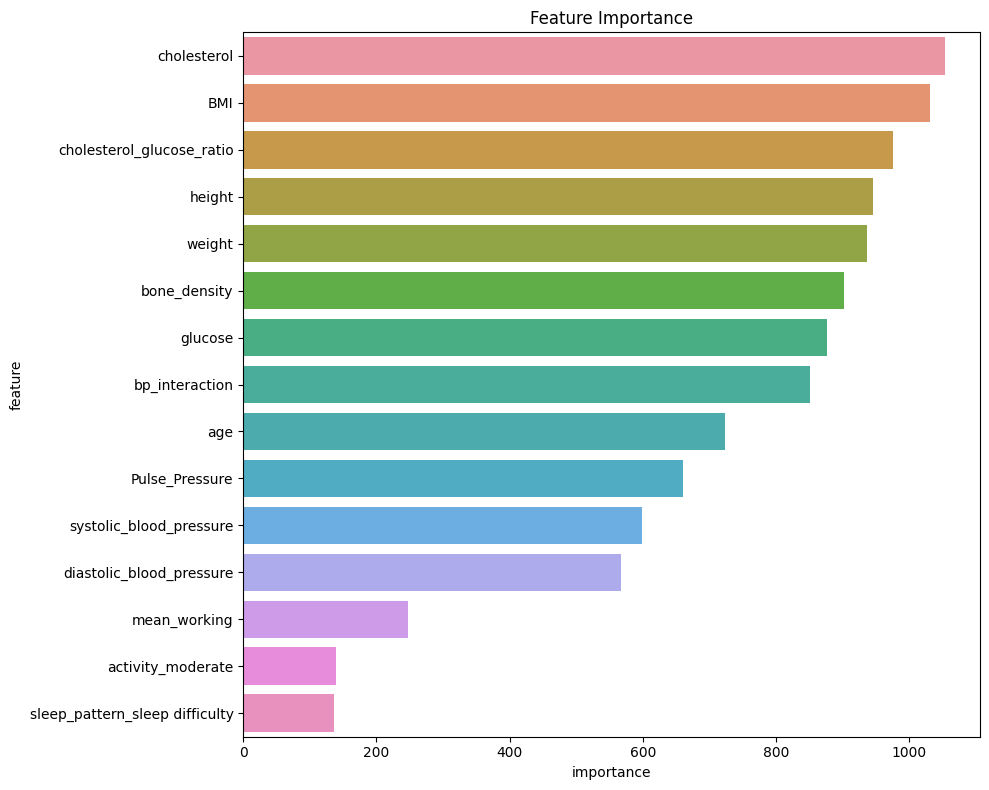

In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 전처리 및 파생변수 생성 함수
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    categorical_cols = ['gender', 'activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Hypertension_flag'] = ((df_processed['systolic_blood_pressure'] >= 140) | (df_processed['diastolic_blood_pressure'] >= 90)).astype(int)
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    bins = [0, 8, 12, 16, 24]
    labels = ['~8h', '8~12h', '12~16h', '16h~']
    df_processed['Working_Hour_Group'] = pd.cut(df_processed['mean_working'], bins=bins, labels=labels, right=False)
    df_processed = pd.get_dummies(df_processed, columns=['Working_Hour_Group'], prefix='Working_Hour_Group', drop_first=True)
    return df_processed

# 3. 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df)
test_final = preprocess_and_feature_engineer(test_df)

# 4. 학습 데이터와 테스트 데이터의 컬럼 일치시키기
train_cols = set(train_final.columns)
test_cols = set(test_final.columns)
common_cols = list(train_cols.intersection(test_cols))
common_cols = [col for col in common_cols if col not in ['ID', 'stress_score']]

X_train = train_final[common_cols]
y_train = train_final['stress_score']
X_test = test_final[common_cols]

# 5. 최종 모델 학습 및 예측 (최적의 파라미터 적용)
lgb_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    num_leaves=40
)
lgb_model.fit(X_train, y_train)
test_predictions = lgb_model.predict(X_test)

# 6. 제출 파일 생성
submission_df['stress_score'] = test_predictions
submission_df.to_csv('../data/submission_tuned.csv', index=False)

print("---")
print("submission_tuned.csv 파일이 성공적으로 생성되었습니다!")

# 7. 변수 중요도 확인 코드 추가
print("\n--- 유효 변수 중요도 순위 ---")
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
})

# 중요도 순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df.head(15)) # 중요도 상위 15개 출력

# 시각화 추가
plt.figure(figsize=(10, 8))
sns.barplot(x="importance", y="feature", data=feature_importance_df.head(15))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()